# Consulta e Preparação de Dados
### CMC-13 - Introdução à Ciência de Dados

* Emanuel Reinaldo Gomes Bezerra
* Pedro Pinheiro Borges
* Guilherme Alt Chagas Merklein

In [195]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

### Leitura dos Arquivos de Dados

In [196]:
books = pd.read_csv("datasets/books.csv", delimiter=';')
users = pd.read_csv("datasets/users.csv", delimiter=';')
ratings = pd.read_csv("datasets/ratings.csv", delimiter=';')

In [197]:
books.columns, users.columns, ratings.columns

(Index(['isbn', 'book_title', 'book_author', 'year_of_publication', 'publisher',
        'img_l', 'Language', 'Category'],
       dtype='object'),
 Index(['user_id', 'age', 'city', 'state', 'country'], dtype='object'),
 Index(['isbn', 'user_id', 'rating'], dtype='object'))

### Criação do Dataset principal

In [198]:
ratings_users = pd.merge(ratings, users, on="user_id", how="inner")
dataset = pd.merge(ratings_users, books, on="isbn", how="inner").dropna()

#Há muitas entries com rating 0, o que não parece ser regular. Vamos considerar que um rating 0 foi um usuário apressado ou que simplesmente não avaliou
dataset = dataset[dataset['rating'] != 0]

In [199]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11659 entries, 0 to 20700
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   isbn                 11659 non-null  object 
 1   user_id              11659 non-null  int64  
 2   rating               11659 non-null  int64  
 3   age                  11659 non-null  float64
 4   city                 11659 non-null  object 
 5   state                11659 non-null  object 
 6   country              11659 non-null  object 
 7   book_title           11659 non-null  object 
 8   book_author          11659 non-null  object 
 9   year_of_publication  11659 non-null  float64
 10  publisher            11659 non-null  object 
 11  img_l                11659 non-null  object 
 12  Language             11659 non-null  object 
 13  Category             11659 non-null  object 
dtypes: float64(2), int64(2), object(10)
memory usage: 1.3+ MB


#### Remoção de Colunas
Removemos ``isbn`` e ``user_id`` pois são identificadores e não possuem informação atrelada a eles.

Removemos ``img_l`` porque é apenas um link para a imagem da capa do livro, sem informação atrelada ao livro.

Removemos ``Language`` porque apresenta dois valores únicos (``en`` e ``9``) com pouca ou nenhuma informação atrelada, pois ``9`` não é um indicativo adequado para idioma.

In [200]:
dataset.Language.unique()

array(['en', '9'], dtype=object)

In [201]:
dataset = dataset.drop(columns=["isbn", "user_id", "img_l", "Language"])

Removemos as colunas ``city``, ``state``, ``country``, porque não estamos interessados em utilizar localização para determinar a avaliação de uma pessoa em um dado livro.

In [202]:
print(len(dataset.country.unique()), len(dataset.state.unique()), len(dataset.city.unique()))

109 451 4016


In [203]:
dataset = dataset.drop(columns=["country", "state", "city"])

Análise das colunas ``book_author``, ``book_title``, ``Category`` e ``publisher``
* Existem algumas linhas cujo ``Category`` é ``9``. Iremos remover esses exemplares porque isto aparenta ser problema de qualidade dos dados.
* A primeira transformação a ser feita é transformar todas os caracteres para minúsculo e remover espaços extras
* Devido ao grande número de tipos dessas propriedades, não é recomendado utilizar one-hot encoding porque gera esparsidade nos dados.
* Para esses campos, posso fazer as transformações: 
  * Label Encoding
  * Embeddings, se quiser usar redes neurais, também pode funcionar bem com árvores utilizando embeddings pré treinados.
  * Não utilizar diretamente, mas em vez disso usar algo como "rating médio por livro/autor"
* Problema: temos poucos dados. Precisaríamos utilizar PCA depois de gerar os embeddings para reduzir sua dimensão por conta da maldição da dimensionalidade. Por isso usaremos Label Encoding.

In [204]:
dataset = dataset[dataset["Category"] != "9"].reset_index(drop=True)

In [205]:
dataset.book_title = dataset.book_title.str.lower().str.strip()
dataset.book_author = dataset.book_author.str.lower().str.strip()
dataset.Category = dataset.Category.str.lower().str.strip()

### Visualizações dos Dados e Análise exploratória

precisa analisar o year_of_publication e age e verificar se ele é uma feature relevante ou nao (analisando se o rating muda conforme ele, agrupando em grupos de 5 ou 10 anos, etc), pode deletar elas se for o caso, se for usar precisaremos deixar entre 0 e 1 para ficar tudo na mesma escala


Optamos por não utilizar age no modelo, por 2 motivos:
- A distribuição de dados não é muito favorável (poucos abaixo de 10 anos e acima de 60, e muitos com exatamente 34 anos: 10x mais que as outras idades)
- Não há um padrão claro quando agrupamos idades próximas, e se houver algo, não temos certeza se é por falta/excesso de dados ou se realmente há uma informação relevante ali

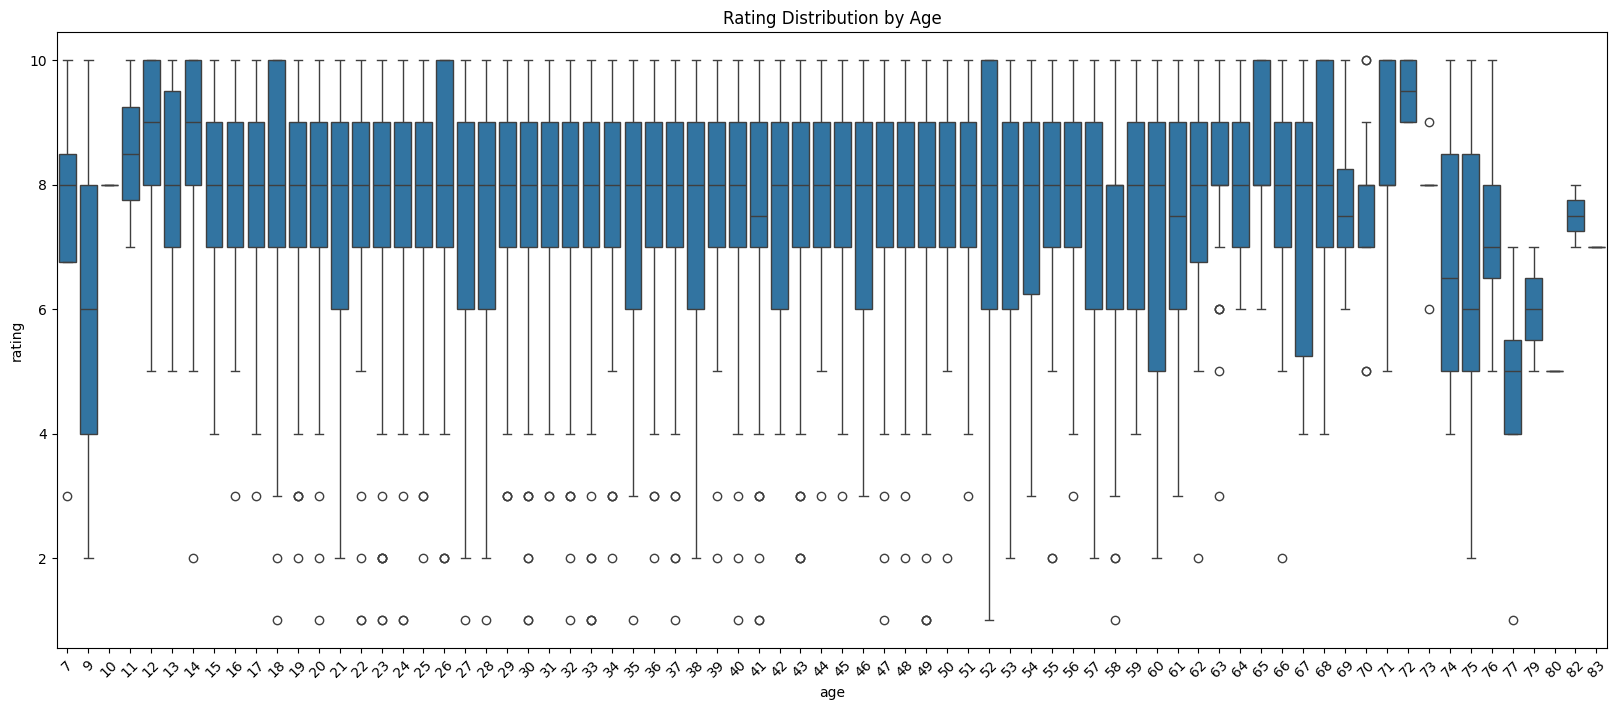

In [206]:
dataset = dataset[dataset['age'] % 1 == 0]  # Há muitas idades com um valor de ponto flutuante igual a 34.74389988072476. Vamos manter apenas as inteiras
dataset['age'] = dataset['age'].astype(int) # Converter idade pra integer

plt.figure(figsize=(20, 8))
sns.boxplot(x='age', y='rating', data=dataset)
plt.title('Rating Distribution by Age')
plt.xticks(rotation=45)
plt.show()

Para o Year of Publication, fazemos uma análise similar ao age

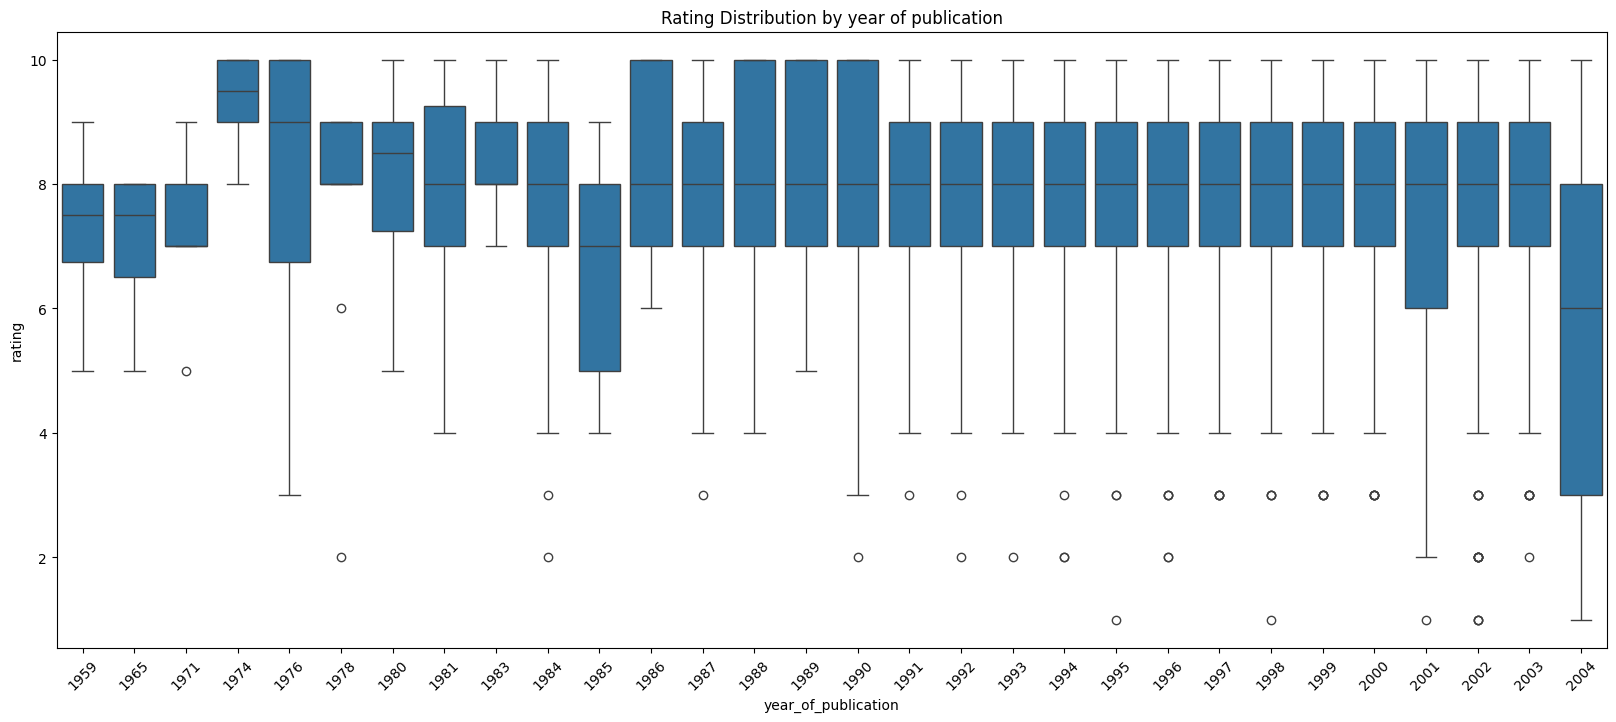

In [207]:
dataset['year_of_publication'] = dataset['year_of_publication'].astype(int)

plt.figure(figsize=(20, 8))
sns.boxplot(x='year_of_publication', y='rating', data=dataset)
plt.title('Rating Distribution by year of publication')
plt.xticks(rotation=45)
plt.show()


Hipótese: Se o livro é da "época" de um usuário, o rating médio tende a ser maior<br>
Conclusão: Difícil de dizer, pois só temos dados livros publicados até 2004, e apesar de sabermos a idade do usuário, não sabemos
em que ano a avaliação dele foi feita. A princípio,a hipótese proposta não foi observada. Porém isso não significa que devemos descartar os dados, pois podem fazer sentido junto com outras features

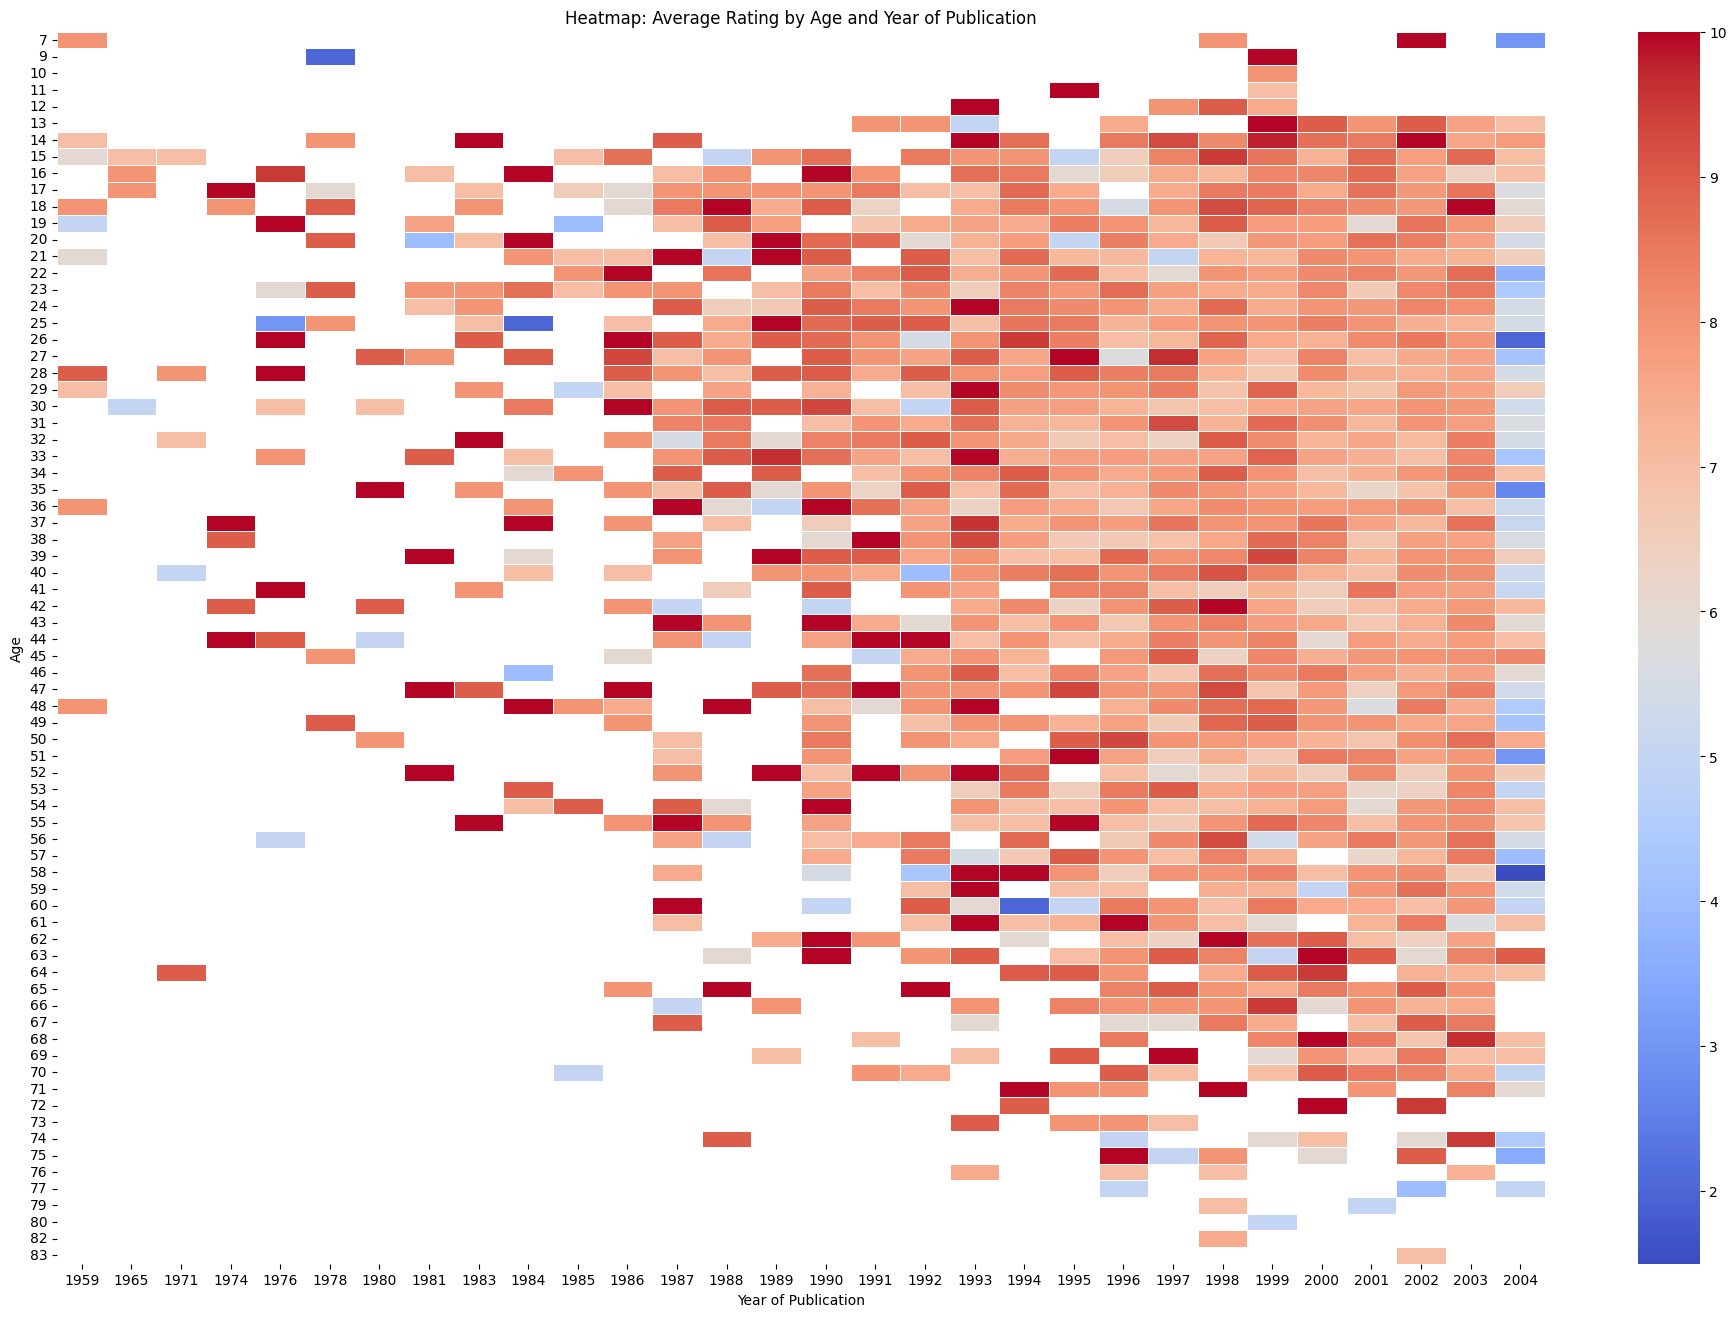

In [208]:
filtered_data = dataset[['age', 'year_of_publication', 'rating']].dropna()
pivot_table = filtered_data.pivot_table(values='rating', index='age', columns='year_of_publication', aggfunc='mean')
plt.figure(figsize=(24, 16))
sns.heatmap(pivot_table, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Heatmap: Average Rating by Age and Year of Publication')
plt.xlabel('Year of Publication')
plt.ylabel('Age')
plt.show()

Para Age e Year of Publication, vamos normalizar os valores.
Como Year Of Publication tem valores muito altos na média, é melhor colocar eles no range de 0 a 1

In [209]:
age_scaler = MinMaxScaler()
year_scaler = MinMaxScaler()

dataset['year_of_publication'] = year_scaler.fit_transform(dataset[['year_of_publication']])
dataset['age'] = age_scaler.fit_transform(dataset[['age']])

#### Análise de book_title
Como são muitos livros no dataset (mais de 5000). Não faz sentido utilizar um one-hot encoding. Além disso, vamos descartar o label encoding, pois não há uma ideia de gradiente. Dois livros muito diferentes podem ficar com labels muito próximas. Em vez disso, vamos utilizar como feature o rating médio de um livro.<br><br>
Problema: Dependendo dos dados que temos, alguns livros podem acabar recebendo ratings que não condizem com a realidade

In [210]:
dataset['book_title'] = dataset['book_title'].str.replace(' ', '', regex=False).str.lower()

dataset['avg_book_rating'] = dataset.groupby('book_title')['rating'].transform('mean')

dataset.head()

,rating,age,book_title,book_author,year_of_publication,publisher,Category,avg_book_rating
1,10,0.421053,thetestament,john grisham,0.888889,Dell,['fiction'],7.214286
2,8,0.605263,thetestament,john grisham,0.888889,Dell,['fiction'],7.214286
11,9,0.539474,thetestament,john grisham,0.888889,Dell,['fiction'],7.214286
13,6,0.565789,thetestament,john grisham,0.888889,Dell,['fiction'],7.214286
18,7,0.802632,thetestament,john grisham,0.888889,Dell,['fiction'],7.214286


#### Análise de book_author
Às vezes um livro ruim de um bom autor pode receber um rating maior. Partindo dessa hipótese, vamos adicionar o avg_author_rating ao dataset, em vez de utilizar diretamente o nome do autor.
Faremos similar a como foi feito o book_title

In [211]:
dataset['book_author'] = dataset['book_author'].str.replace(' ', '', regex=False).str.lower()

dataset['avg_author_rating'] = dataset.groupby('book_author')['rating'].transform('mean')

dataset.head()

,rating,age,book_title,book_author,year_of_publication,publisher,Category,avg_book_rating,avg_author_rating
1,10,0.421053,thetestament,johngrisham,0.888889,Dell,['fiction'],7.214286,7.569378
2,8,0.605263,thetestament,johngrisham,0.888889,Dell,['fiction'],7.214286,7.569378
11,9,0.539474,thetestament,johngrisham,0.888889,Dell,['fiction'],7.214286,7.569378
13,6,0.565789,thetestament,johngrisham,0.888889,Dell,['fiction'],7.214286,7.569378
18,7,0.802632,thetestament,johngrisham,0.888889,Dell,['fiction'],7.214286,7.569378


#### Análise de publisher
Vamos verificar o impacto de publisher nos dados<br>
Temos 124 publishers not total, e como é possível observar no gráfico abaixo, eles podem influenciar nas ratings.<br>
Vamos seguir a mesma lógica acima e acrescentar o rating médio do publisher como feature

124


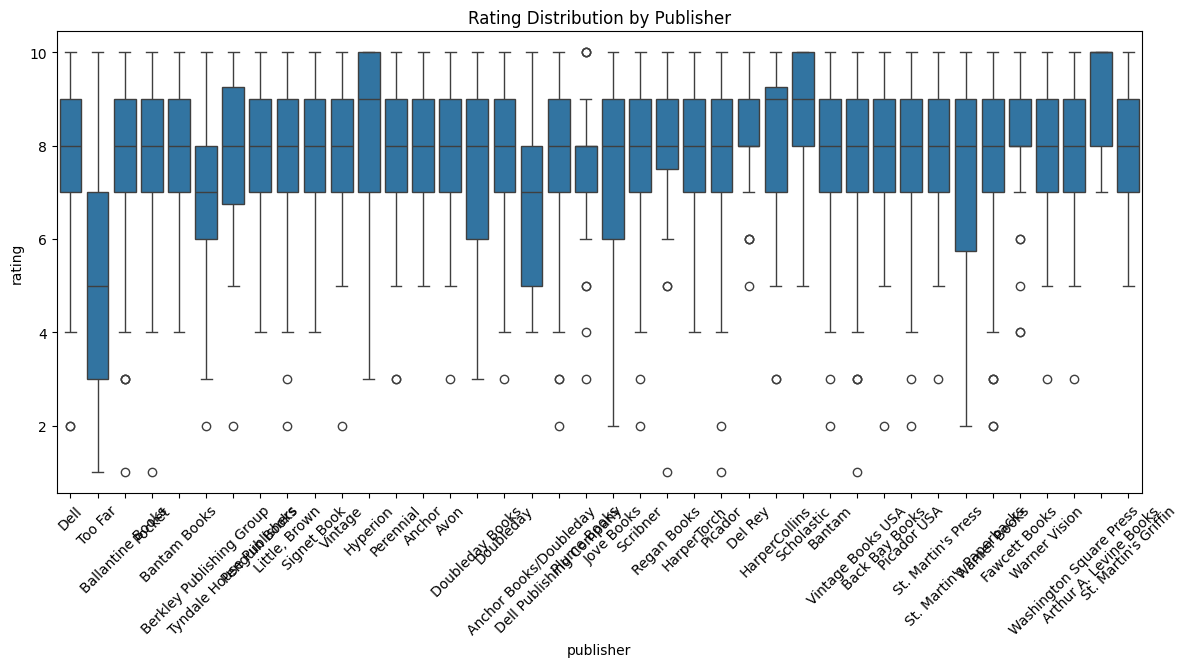

In [212]:
top_publishers = dataset['publisher'].value_counts().nlargest(40).index
filtered_data = dataset[dataset['publisher'].isin(top_publishers)]
print(len(dataset['publisher'].unique()))
plt.figure(figsize=(14, 6))
sns.boxplot(x='publisher', y='rating', data=filtered_data)
plt.title('Rating Distribution by Publisher')
plt.xticks(rotation=45)
plt.show()

In [213]:
dataset['publisher'] = dataset['publisher'].str.replace(' ', '', regex=False).str.lower()

dataset['avg_publisher_rating'] = dataset.groupby('publisher')['rating'].transform('mean')

dataset.head()

,rating,age,book_title,book_author,year_of_publication,publisher,Category,avg_book_rating,avg_author_rating,avg_publisher_rating
1,10,0.421053,thetestament,johngrisham,0.888889,dell,['fiction'],7.214286,7.569378,7.76
2,8,0.605263,thetestament,johngrisham,0.888889,dell,['fiction'],7.214286,7.569378,7.76
11,9,0.539474,thetestament,johngrisham,0.888889,dell,['fiction'],7.214286,7.569378,7.76
13,6,0.565789,thetestament,johngrisham,0.888889,dell,['fiction'],7.214286,7.569378,7.76
18,7,0.802632,thetestament,johngrisham,0.888889,dell,['fiction'],7.214286,7.569378,7.76


#### Análise de Category
Vamos ver como a categoria impacta no rating.<br>
Observando o gráfico abaixo, vemos que a categoria de um livro influencia no rating. Como há menos categorias que livros/autores/publishers, podemos tentar outro tipo to encoding, como um one-hot ou um label.<br>
O problema de usar one-hot é que ainda são várias categorias, o que prejudicaria a dimensionalidade do modelo e cálculos de distâncias.<br>
O problema do label encoder é que ele irá dar valores numéricos arbitrários às categorias, sem pensar na ideia de um gradiente entre elas
<br><br>
Hipótese:<br>
Há uma relação grande entre autor e categoria (um dado autor vai focar em uma categoria específica), de modo que o par ordenado (avg_author_rating, category) pode ser um melhor identificador para um autor do que apenas avg_author_rating. Desse modo, pode fazer sentido utilizar um label encoder para categoria

52


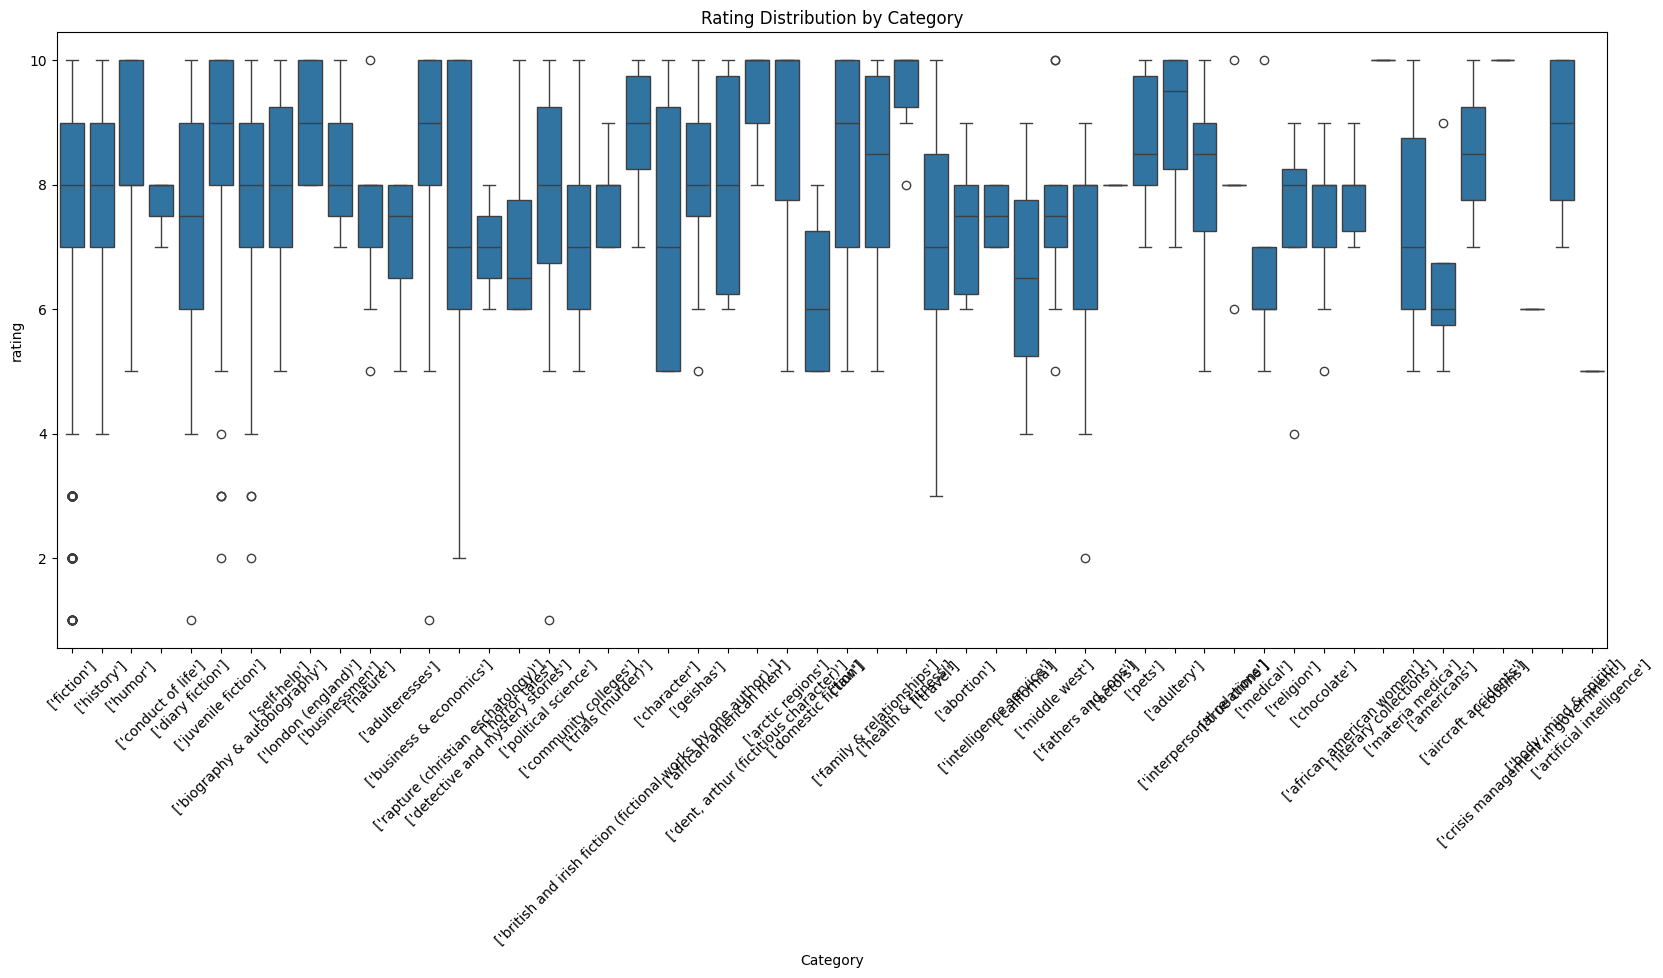

In [214]:
print(len(dataset['Category'].unique()))
plt.figure(figsize=(20, 8))
sns.boxplot(x='Category', y='rating', data=dataset)
plt.title('Rating Distribution by Category')
plt.xticks(rotation=45)
plt.show()

O plot abaixo mostra que a maioria dos autores fica em uma só categoria, como desejado. Então utilizaremos um label encoder para diferenciar as diferentes categorias

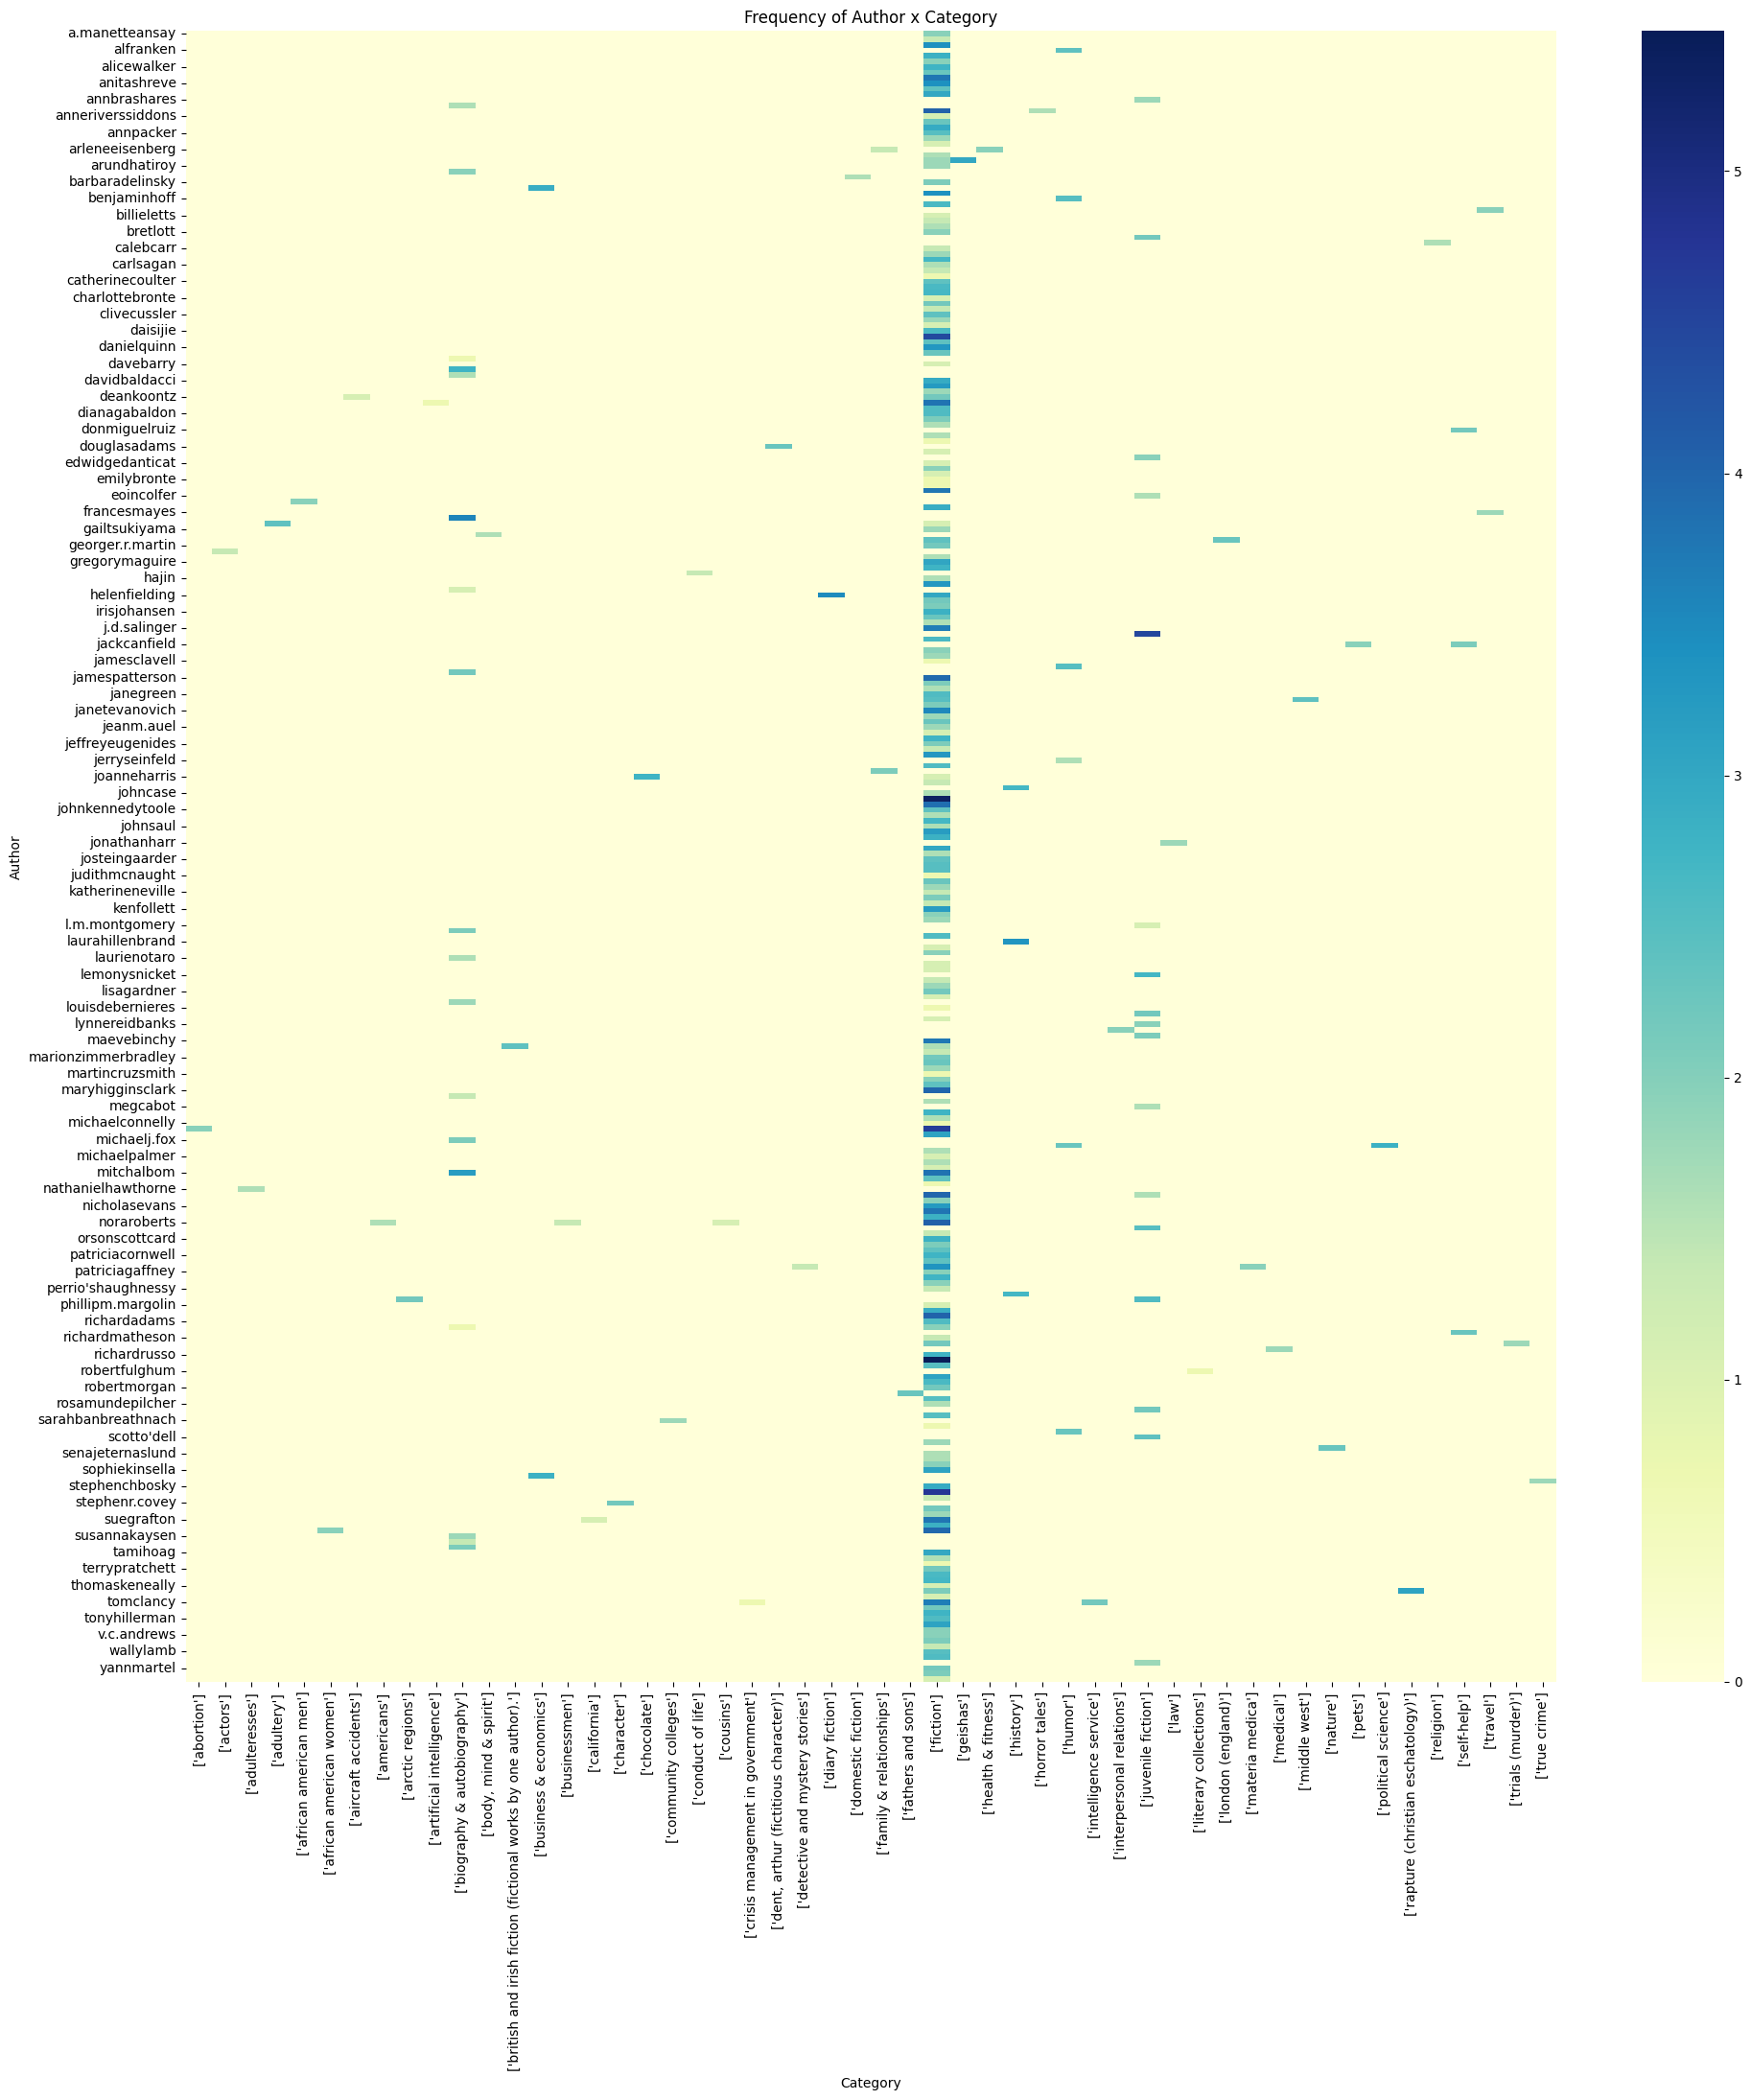

In [ ]:
author_category_counts = dataset.pivot_table(
    index='book_author',
    columns='Category',
    values='rating', 
    aggfunc='count',
    fill_value=0
)

sampled_authors = author_category_counts.sample(n=50, random_state=1)

log_counts = np.log1p(sampled_authors) # ESCALA LOGARITMICA
plt.figure(figsize=(20, 22))
sns.heatmap(log_counts, annot=False, fmt=".2f", cmap='YlGnBu')
plt.title('Frequency of Author x Category')
plt.xlabel('Category')
plt.ylabel('Author')
plt.tight_layout()
plt.show()

In [188]:
category_encoder = LabelEncoder()
dataset['category_encoded'] = category_encoder.fit_transform(dataset['Category'])

dataset.head()

,rating,age,book_title,book_author,year_of_publication,publisher,Category,avg_book_rating,avg_author_rating,avg_publisher_rating,category_encoded
1,10,0.421053,thetestament,johngrisham,0.888889,dell,['fiction'],7.214286,7.569378,7.76,28
2,8,0.605263,thetestament,johngrisham,0.888889,dell,['fiction'],7.214286,7.569378,7.76,28
11,9,0.539474,thetestament,johngrisham,0.888889,dell,['fiction'],7.214286,7.569378,7.76,28
13,6,0.565789,thetestament,johngrisham,0.888889,dell,['fiction'],7.214286,7.569378,7.76,28
18,7,0.802632,thetestament,johngrisham,0.888889,dell,['fiction'],7.214286,7.569378,7.76,28


#### Remover colunas que não serão utilizadas

In [189]:
dataset = dataset.drop(columns=["book_title", "book_author", "publisher", "Category"])
dataset.head()

,rating,age,year_of_publication,avg_book_rating,avg_author_rating,avg_publisher_rating,category_encoded
1,10,0.421053,0.888889,7.214286,7.569378,7.76,28
2,8,0.605263,0.888889,7.214286,7.569378,7.76,28
11,9,0.539474,0.888889,7.214286,7.569378,7.76,28
13,6,0.565789,0.888889,7.214286,7.569378,7.76,28
18,7,0.802632,0.888889,7.214286,7.569378,7.76,28


#### Transformar dados
Como os valores avg_author_rating, avg_book_rating e avg_publisher_rating podem estar próximos, vamos fazer um MinMaxScaling neles.<br>
Porém, não faremos isso com category_encoded, porque não há uma noção de distância entre as categorias. Dependendo do modelo a ser usado, não faz sentido

In [190]:
aprs = MinMaxScaler()
abrs = MinMaxScaler()
aars = MinMaxScaler()

dataset["avg_book_rating"] = abrs.fit_transform(dataset[["avg_book_rating"]])
dataset["avg_author_rating"] = aars.fit_transform(dataset[["avg_author_rating"]])
dataset["avg_publisher_rating"] = aprs.fit_transform(dataset[["avg_publisher_rating"]])

dataset.head()

,rating,age,year_of_publication,avg_book_rating,avg_author_rating,avg_publisher_rating,category_encoded
1,10,0.421053,0.888889,0.535714,0.527155,0.564238,28
2,8,0.605263,0.888889,0.535714,0.527155,0.564238,28
11,9,0.539474,0.888889,0.535714,0.527155,0.564238,28
13,6,0.565789,0.888889,0.535714,0.527155,0.564238,28
18,7,0.802632,0.888889,0.535714,0.527155,0.564238,28


In [191]:
dataset_x = dataset[["age", "year_of_publication", "avg_book_rating", "avg_author_rating", "avg_publisher_rating", "category_encoded"]]
dataset_y = dataset[["rating"]]

In [192]:
dataset.head()

,rating,age,year_of_publication,avg_book_rating,avg_author_rating,avg_publisher_rating,category_encoded
1,10,0.421053,0.888889,0.535714,0.527155,0.564238,28
2,8,0.605263,0.888889,0.535714,0.527155,0.564238,28
11,9,0.539474,0.888889,0.535714,0.527155,0.564238,28
13,6,0.565789,0.888889,0.535714,0.527155,0.564238,28
18,7,0.802632,0.888889,0.535714,0.527155,0.564238,28


In [193]:
X_train, X_test, y_train, y_test = train_test_split(dataset_x, dataset_y, test_size=0.2, random_state=1)
dados_treinamento = X_train.join(y_train)
dados_teste = X_test.join(y_test)

In [194]:
dataset.to_csv("datasets/dataset.csv", index=False)
dados_teste.to_csv("datasets/dados_teste.csv", index=False)
dados_treinamento.to_csv("datasets/dados_treinamento.csv", index=False)